# 1D coordinate basis

First we include the Gadfly library for plotting. 

Secondly, we set up the coordinate mesh on which we solve the Sch. equation for the harmonic oscillator potential. Here we deal with a simple 1D harmonic oscillator. We choose the Fourier mesh over the interval $\left\langle -N/2, N/2\right\rangle$.

We set number of mesh points and distribute them evenly 

In [1]:
using Gadfly

In [2]:
nmesh = 51; # mesh size
mesh = [1:nmesh] - (nmesh+1)/2;
scale = 0.35;

lambda = 1;
println(mesh)
println(scale*mesh)

evals = 0.5*(2*[1:nmesh] - 1);

[-25.0,-24.0,-23.0,-22.0,-21.0,-20.0,-19.0,-18.0,-17.0,-16.0,-15.0,-14.0,-13.0,-12.0,-11.0,-10.0,-9.0,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0]
[-8.75,-8.399999999999999,-8.049999999999999,-7.699999999999999,-7.35,-7.0,-6.6499999999999995,-6.3,-5.949999999999999,-5.6,-5.25,-4.8999999999999995,-4.55,-4.199999999999999,-3.8499999999999996,-3.5,-3.15,-2.8,-2.4499999999999997,-2.0999999999999996,-1.75,-1.4,-1.0499999999999998,-0.7,-0.35,0.0,0.35,0.7,1.0499999999999998,1.4,1.75,2.0999999999999996,2.4499999999999997,2.8,3.15,3.5,3.8499999999999996,4.199999999999999,4.55,4.8999999999999995,5.25,5.6,5.949999999999999,6.3,6.6499999999999995,7.0,7.35,7.699999999999999,8.049999999999999,8.399999999999999,8.75]


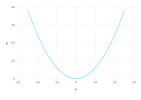

In [3]:
# potential plot
pot = 0.5*scale*scale*mesh.*mesh;

plot(x = mesh, y = pot, Geom.line)

In [4]:
function kinetic(i, j, mesh)
  n = size(mesh)[1];
  if(i == j)
    pi23 = pi*pi/3.0;
    n1 = 1/(n*n);
    return pi23*(1.0 - n1);
  else
    fac1 = (-1.0)^(i-j);
    fac2 = 2*pi*pi/(n*n);
    facpin = pi/n;
    fac3 = cos(facpin*(mesh[i] - mesh[j]));
    fac4 = sin(facpin*(mesh[i] - mesh[j]));
    return fac1*fac2*fac3/(fac4*fac4);
  end
end

function potential(x,scale)
  return 0.5*scale*scale*x.*x
end

function basis_func_primitive(x, j, mesh)
  nmesh = size(mesh)[1];
  
  fac1 = sin(pi*(x - mesh[j]))
  fac2 = sin(pi*(x - mesh[j])/nmesh)
  
  return fac1/(nmesh*fac2)
end

function basis_func(x, j, mesh, scale)
  return basis_func_primitive(x/scale, j, mesh)/sqrt(scale)
end

basis_func (generic function with 1 method)

In [5]:
function wfun(qnum, eigvec, out_mesh, in_mesh, scale)
  nom = size(out_mesh)[1];
  nim = size(in_mesh)[1];
  wf = zeros(nom);
  
  for i = 1:nom
    wf[i] = 0.0;
    for j = 1:nim
      wf[i] = wf[i] + eigvec[j]*basis_func(out_mesh[i], j, in_mesh, scale);
    end
  end
  
  return wf;
end

wfun (generic function with 1 method)

In [6]:
hamiltonian = zeros(nmesh,nmesh);
for row = 1:nmesh
  for col = 1:nmesh
    hamiltonian[row,col] = 0.5*kinetic(row,col,mesh)/(scale*scale);
  end
end
hamiltonian = hamiltonian + diagm(vec(potential(mesh,scale)));

0.9999999999999998


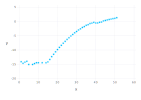

In [7]:
F = eigfact(hamiltonian);
s = sum(F[:vectors][:,1].*F[:vectors][:,1])
println(s)

plot(x = [1:nmesh], y = log10(abs(evals - F[:values])), Geom.point)

In [8]:
xplot = [1:1001]/50 - 10.0 + 1e-6;
eigenvalue_index = 2

fig_wf0 = plot(x = xplot, y = wfun(1, F[:vectors][:,1], xplot, mesh, scale), Geom.line)
display(fig_wf0)
fig_wf1 = plot(x = xplot, y = wfun(2, F[:vectors][:,2], xplot, mesh, scale), Geom.line)
display(fig_wf1)
fig_wf2 = plot(x = xplot, y = wfun(3, F[:vectors][:,3], xplot, mesh, scale), Geom.line)
display(fig_wf2)
fig_wf3 = plot(x = xplot, y = wfun(4, F[:vectors][:,4], xplot, mesh, scale), Geom.line)
display(fig_wf3)
#gridstack([fig_wf0 fig_wf1; fig_wf2 fig_wf3])

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 x 
 
 
 -40 
 -35 
 -30 
 -25 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 25 
 30 
 35 
 40 
 45 
 -35 
 -34 
 -33 
 -32 
 -31 
 -30 
 -29 
 -28 
 -27 
 -26 
 -25 
 -24 
 -23 
 -22 
 -21 
 -20 
 -19 
 -18 
 -17 
 -16 
 -15 
 -14 
 -13 
 -12 
 -11 
 -10 
 -9 
 -8 
 -7 
 -6 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 40 
 -40 
 -20 
 0 
 20 
 40 
 -36 
 -34 
 -32 
 -30 
 -28 
 -26 
 -24 
 -22 
 -20 
 -18 
 -16 
 -14 
 -12 
 -10 
 -8 
 -6 
 -4 
 -2 
 0 
 2 
 4 
 6 
 8 
 10 
 12 
 14 
 16 
 18 
 20 
 22 
 24 
 26 
 28 
 30 
 32 
 34 
 36 
 38 
 40 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M20.03,64.37 L 20.12 64.37 20.21 64.37 20.31 64.37 20.4 64.37 20.49 64.37 20.58 64.37 20.67 64.37 20.76 64.37 20.86 64.37 20.95 64.37 21.04 64.37 21.13 64.37 21.22 64.37 21.31 64.37 21.4 64.37 21.5 64.37 21.59 64.37 21.68 64.37 21.77 64.37 21.86 64.37 21.95 64.37 22.05 64.37 22.14 64.37 22.23 64.37 22.32 64.37 22.41 64.37 22.5 64.37 22.6 64.37 22.69 64.37 22.78 64.37 22.87 64.37 22.96 64.37 23.05 64.37 23.14 64.37 23.24 64.37 23.33 64.37 23.42 64.37 23.51 64.37 23.6 64.37 23.69 64.37 23.79 64.37 23.88 64.37 23.97 64.37 24.06 64.37 24.15 64.37 24.24 64.37 24.34 64.37 24.43 64.37 24.52 64.37 24.61 64.37 24.7 64.37 24.79 64.37 24.88 64.37 24.98 64.37 25.07 64.37 25.16 64.37 25.25 64.37 25.34 64.37 25.43 64.37 25.53 64.37 25.62 64.37 25.71 64.37 25.8 64.37 25.89 64.37 25.98 64.37 26.08 64.37 26.17 64.37 26.26 64.37 26.35 64.37 26.44 64.37 26.53 64.37 26.62 64.37 26.72 64.37 26.81 64.37 26.9 64.37 26.99 64.37 27.08 64.37 27.17 64.37 27.27 64.37 27.36 64.37 27.45 64.37 27.54 64.37 27.63 64.37 27.72 64.37 27.82 64.37 27.91 64.37 28 64.37 28.09 64.37 28.18 64.37 28.27 64.37 28.37 64.37 28.46 64.37 28.55 64.37 28.64 64.37 28.73 64.37 28.82 64.37 28.91 64.37 29.01 64.37 29.1 64.37 29.19 64.37 29.28 64.37 29.37 64.37 29.46 64.37 29.56 64.37 29.65 64.37 29.74 64.37 29.83 64.37 29.92 64.37 30.01 64.37 30.11 64.37 30.2 64.37 30.29 64.37 30.38 64.37 30.47 64.37 30.56 64.37 30.65 64.37 30.75 64.37 30.84 64.37 30.93 64.37 31.02 64.37 31.11 64.37 31.2 64.37 31.3 64.37 31.39 64.37 31.48 64.37 31.57 64.37 31.66 64.37 31.75 64.37 31.85 64.37 31.94 64.37 32.03 64.37 32.12 64.37 32.21 64.37 32.3 64.37 32.39 64.37 32.49 64.37 32.58 64.37 32.67 64.37 32.76 64.37 32.85 64.37 32.94 64.37 33.04 64.37 33.13 64.37 33.22 64.37 33.31 64.37 33.4 64.37 33.49 64.37 33.59 64.37 33.68 64.37 33.77 64.37 33.86 64.37 33.95 64.37 34.04 64.37 34.13 64.37 34.23 64.37 34.32 64.37 34.41 64.37 34.5 64.37 34.59 64.37 34.68 64.37 34.78 64.37 34.87 64.37 34.96 64.37 35.05 64.37 35.14 64.37 35.23 64.37 35.33 64.37 35.42 64.37 35.51 64.37 35.6 64.37 35.69 64.37 35.78 64.37 35.88 64.37 35.97 64.37 36.06 64.37 36.15 64.37 36.24 64.37 36.33 64.37 36.42 64.37 36.52 64.37 36.61 64.37 36.7 64.37 36.79 64.37 36.88 64.37 36.97 64.37 37.07 64.37 37.16 64.37 37.25 64.37 37.34 64.37 37.43 64.37 37.52 64.37 37.62 64.37 37.71 64.37 37.8 64.37 37.89 64.37 37.98 64.37 38.07 64.37 38.16 64.37 38.26 64.37 38.35 64.37 38.44 64.37 38.53 64.37 38.62 64.37 38.71 64.37 38.81 64.37 38.9 64.37 38.99 64.37 39.08 64.37 39.17 64.37 39.26 64.37 39.36 64.37 39.45 64.37 39.54 64.37 39.63 64.37 39.72 64.37 39.81 64.37 39.9 64.37 40 64.37 40.09 64.37 40.18 64.37 40.27 64.37 40.36 64.37 40.45 64.37 40.55 64

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 x 
 
 
 -40 
 -35 
 -30 
 -25 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 25 
 30 
 35 
 40 
 45 
 -35 
 -34 
 -33 
 -32 
 -31 
 -30 
 -29 
 -28 
 -27 
 -26 
 -25 
 -24 
 -23 
 -22 
 -21 
 -20 
 -19 
 -18 
 -17 
 -16 
 -15 
 -14 
 -13 
 -12 
 -11 
 -10 
 -9 
 -8 
 -7 
 -6 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 40 
 -40 
 -20 
 0 
 20 
 40 
 -36 
 -34 
 -32 
 -30 
 -28 
 -26 
 -24 
 -22 
 -20 
 -18 
 -16 
 -14 
 -12 
 -10 
 -8 
 -6 
 -4 
 -2 
 0 
 2 
 4 
 6 
 8 
 10 
 12 
 14 
 16 
 18 
 20 
 22 
 24 
 26 
 28 
 30 
 32 
 34 
 36 
 38 
 40 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M20.03,42.86 L 20.12 42.86 20.21 42.86 20.31 42.86 20.4 42.86 20.49 42.86 20.58 42.86 20.67 42.86 20.76 42.86 20.86 42.86 20.95 42.86 21.04 42.86 21.13 42.86 21.22 42.86 21.31 42.86 21.4 42.86 21.5 42.86 21.59 42.86 21.68 42.86 21.77 42.86 21.86 42.86 21.95 42.86 22.05 42.86 22.14 42.86 22.23 42.86 22.32 42.86 22.41 42.86 22.5 42.86 22.6 42.86 22.69 42.86 22.78 42.86 22.87 42.86 22.96 42.86 23.05 42.86 23.14 42.86 23.24 42.86 23.33 42.86 23.42 42.86 23.51 42.86 23.6 42.86 23.69 42.86 23.79 42.86 23.88 42.86 23.97 42.86 24.06 42.86 24.15 42.86 24.24 42.86 24.34 42.86 24.43 42.86 24.52 42.86 24.61 42.86 24.7 42.86 24.79 42.86 24.88 42.86 24.98 42.86 25.07 42.86 25.16 42.86 25.25 42.86 25.34 42.86 25.43 42.86 25.53 42.86 25.62 42.86 25.71 42.86 25.8 42.86 25.89 42.86 25.98 42.86 26.08 42.86 26.17 42.86 26.26 42.86 26.35 42.86 26.44 42.86 26.53 42.86 26.62 42.86 26.72 42.86 26.81 42.86 26.9 42.86 26.99 42.86 27.08 42.86 27.17 42.86 27.27 42.86 27.36 42.86 27.45 42.86 27.54 42.86 27.63 42.86 27.72 42.86 27.82 42.86 27.91 42.86 28 42.86 28.09 42.86 28.18 42.86 28.27 42.86 28.37 42.86 28.46 42.86 28.55 42.86 28.64 42.86 28.73 42.86 28.82 42.86 28.91 42.86 29.01 42.86 29.1 42.86 29.19 42.86 29.28 42.86 29.37 42.86 29.46 42.86 29.56 42.86 29.65 42.86 29.74 42.86 29.83 42.86 29.92 42.86 30.01 42.86 30.11 42.86 30.2 42.86 30.29 42.86 30.38 42.86 30.47 42.86 30.56 42.86 30.65 42.86 30.75 42.86 30.84 42.86 30.93 42.86 31.02 42.86 31.11 42.86 31.2 42.86 31.3 42.86 31.39 42.86 31.48 42.86 31.57 42.86 31.66 42.86 31.75 42.86 31.85 42.86 31.94 42.86 32.03 42.86 32.12 42.86 32.21 42.86 32.3 42.86 32.39 42.86 32.49 42.86 32.58 42.86 32.67 42.86 32.76 42.86 32.85 42.86 32.94 42.86 33.04 42.86 33.13 42.86 33.22 42.86 33.31 42.86 33.4 42.86 33.49 42.86 33.59 42.86 33.68 42.86 33.77 42.86 33.86 42.86 33.95 42.86 34.04 42.86 34.13 42.86 34.23 42.86 34.32 42.86 34.41 42.86 34.5 42.86 34.59 42.86 34.68 42.86 34.78 42.86 34.87 42.86 34.96 42.86 35.05 42.86 35.14 42.86 35.23 42.86 35.33 42.86 35.42 42.86 35.51 42.86 35.6 42.86 35.69 42.86 35.78 42.86 35.88 42.86 35.97 42.86 36.06 42.86 36.15 42.86 36.24 42.86 36.33 42.86 36.42 42.86 36.52 42.86 36.61 42.86 36.7 42.86 36.79 42.86 36.88 42.86 36.97 42.86 37.07 42.86 37.16 42.86 37.25 42.86 37.34 42.86 37.43 42.86 37.52 42.86 37.62 42.86 37.71 42.86 37.8 42.86 37.89 42.86 37.98 42.86 38.07 42.86 38.16 42.86 38.26 42.86 38.35 42.86 38.44 42.86 38.53 42.86 38.62 42.86 38.71 42.86 38.81 42.86 38.9 42.86 38.99 42.86 39.08 42.86 39.17 42.86 39.26 42.86 39.36 42.86 39.45 42.86 39.54 42.86 39.63 42.86 39.72 42.86 39.81 42.86 39.9 42.86 40 42.86 40.09 42.86 40.18 42.86 40.27 42.86 40.36 42.86 40.45 42.86 40.55 42.86 40.64 

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 x 
 
 
 -40 
 -35 
 -30 
 -25 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 25 
 30 
 35 
 40 
 45 
 -35 
 -34 
 -33 
 -32 
 -31 
 -30 
 -29 
 -28 
 -27 
 -26 
 -25 
 -24 
 -23 
 -22 
 -21 
 -20 
 -19 
 -18 
 -17 
 -16 
 -15 
 -14 
 -13 
 -12 
 -11 
 -10 
 -9 
 -8 
 -7 
 -6 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 40 
 -40 
 -20 
 0 
 20 
 40 
 -36 
 -34 
 -32 
 -30 
 -28 
 -26 
 -24 
 -22 
 -20 
 -18 
 -16 
 -14 
 -12 
 -10 
 -8 
 -6 
 -4 
 -2 
 0 
 2 
 4 
 6 
 8 
 10 
 12 
 14 
 16 
 18 
 20 
 22 
 24 
 26 
 28 
 30 
 32 
 34 
 36 
 38 
 40 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M20.03,42.86 L 20.12 42.86 20.21 42.86 20.31 42.86 20.4 42.86 20.49 42.86 20.58 42.86 20.67 42.86 20.76 42.86 20.86 42.86 20.95 42.86 21.04 42.86 21.13 42.86 21.22 42.86 21.31 42.86 21.4 42.86 21.5 42.86 21.59 42.86 21.68 42.86 21.77 42.86 21.86 42.86 21.95 42.86 22.05 42.86 22.14 42.86 22.23 42.86 22.32 42.86 22.41 42.86 22.5 42.86 22.6 42.86 22.69 42.86 22.78 42.86 22.87 42.86 22.96 42.86 23.05 42.86 23.14 42.86 23.24 42.86 23.33 42.86 23.42 42.86 23.51 42.86 23.6 42.86 23.69 42.86 23.79 42.86 23.88 42.86 23.97 42.86 24.06 42.86 24.15 42.86 24.24 42.86 24.34 42.86 24.43 42.86 24.52 42.86 24.61 42.86 24.7 42.86 24.79 42.86 24.88 42.86 24.98 42.86 25.07 42.86 25.16 42.86 25.25 42.86 25.34 42.86 25.43 42.86 25.53 42.86 25.62 42.86 25.71 42.86 25.8 42.86 25.89 42.86 25.98 42.86 26.08 42.86 26.17 42.86 26.26 42.86 26.35 42.86 26.44 42.86 26.53 42.86 26.62 42.86 26.72 42.86 26.81 42.86 26.9 42.86 26.99 42.86 27.08 42.86 27.17 42.86 27.27 42.86 27.36 42.86 27.45 42.86 27.54 42.86 27.63 42.86 27.72 42.86 27.82 42.86 27.91 42.86 28 42.86 28.09 42.86 28.18 42.86 28.27 42.86 28.37 42.86 28.46 42.86 28.55 42.86 28.64 42.86 28.73 42.86 28.82 42.86 28.91 42.86 29.01 42.86 29.1 42.86 29.19 42.86 29.28 42.86 29.37 42.86 29.46 42.86 29.56 42.86 29.65 42.86 29.74 42.86 29.83 42.86 29.92 42.86 30.01 42.86 30.11 42.86 30.2 42.86 30.29 42.86 30.38 42.86 30.47 42.86 30.56 42.86 30.65 42.86 30.75 42.86 30.84 42.86 30.93 42.86 31.02 42.86 31.11 42.86 31.2 42.86 31.3 42.86 31.39 42.86 31.48 42.86 31.57 42.86 31.66 42.86 31.75 42.86 31.85 42.86 31.94 42.86 32.03 42.86 32.12 42.86 32.21 42.86 32.3 42.86 32.39 42.86 32.49 42.86 32.58 42.86 32.67 42.86 32.76 42.86 32.85 42.86 32.94 42.86 33.04 42.86 33.13 42.86 33.22 42.86 33.31 42.86 33.4 42.86 33.49 42.86 33.59 42.86 33.68 42.86 33.77 42.86 33.86 42.86 33.95 42.86 34.04 42.86 34.13 42.86 34.23 42.86 34.32 42.86 34.41 42.86 34.5 42.86 34.59 42.86 34.68 42.86 34.78 42.86 34.87 42.86 34.96 42.86 35.05 42.86 35.14 42.86 35.23 42.86 35.33 42.86 35.42 42.86 35.51 42.86 35.6 42.86 35.69 42.86 35.78 42.86 35.88 42.86 35.97 42.86 36.06 42.86 36.15 42.86 36.24 42.86 36.33 42.86 36.42 42.86 36.52 42.86 36.61 42.86 36.7 42.86 36.79 42.86 36.88 42.86 36.97 42.86 37.07 42.86 37.16 42.86 37.25 42.86 37.34 42.86 37.43 42.86 37.52 42.86 37.62 42.86 37.71 42.86 37.8 42.86 37.89 42.86 37.98 42.86 38.07 42.86 38.16 42.86 38.26 42.86 38.35 42.86 38.44 42.86 38.53 42.86 38.62 42.86 38.71 42.86 38.81 42.86 38.9 42.86 38.99 42.86 39.08 42.86 39.17 42.86 39.26 42.86 39.36 42.86 39.45 42.86 39.54 42.86 39.63 42.86 39.72 42.86 39.81 42.86 39.9 42.86 40 42.86 40.09 42.86 40.18 42.86 40.27 42.86 40.36 42.86 40.45 42.86 40.55 42.86 40.64 

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 x 
 
 
 -40 
 -35 
 -30 
 -25 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 25 
 30 
 35 
 40 
 45 
 -35 
 -34 
 -33 
 -32 
 -31 
 -30 
 -29 
 -28 
 -27 
 -26 
 -25 
 -24 
 -23 
 -22 
 -21 
 -20 
 -19 
 -18 
 -17 
 -16 
 -15 
 -14 
 -13 
 -12 
 -11 
 -10 
 -9 
 -8 
 -7 
 -6 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 40 
 -40 
 -20 
 0 
 20 
 40 
 -36 
 -34 
 -32 
 -30 
 -28 
 -26 
 -24 
 -22 
 -20 
 -18 
 -16 
 -14 
 -12 
 -10 
 -8 
 -6 
 -4 
 -2 
 0 
 2 
 4 
 6 
 8 
 10 
 12 
 14 
 16 
 18 
 20 
 22 
 24 
 26 
 28 
 30 
 32 
 34 
 36 
 38 
 40 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M20.03,42.86 L 20.12 42.86 20.21 42.86 20.31 42.86 20.4 42.86 20.49 42.86 20.58 42.86 20.67 42.86 20.76 42.86 20.86 42.86 20.95 42.86 21.04 42.86 21.13 42.86 21.22 42.86 21.31 42.86 21.4 42.86 21.5 42.86 21.59 42.86 21.68 42.86 21.77 42.86 21.86 42.86 21.95 42.86 22.05 42.86 22.14 42.86 22.23 42.86 22.32 42.86 22.41 42.86 22.5 42.86 22.6 42.86 22.69 42.86 22.78 42.86 22.87 42.86 22.96 42.86 23.05 42.86 23.14 42.86 23.24 42.86 23.33 42.86 23.42 42.86 23.51 42.86 23.6 42.86 23.69 42.86 23.79 42.86 23.88 42.86 23.97 42.86 24.06 42.86 24.15 42.86 24.24 42.86 24.34 42.86 24.43 42.86 24.52 42.86 24.61 42.86 24.7 42.86 24.79 42.86 24.88 42.86 24.98 42.86 25.07 42.86 25.16 42.86 25.25 42.86 25.34 42.86 25.43 42.86 25.53 42.86 25.62 42.86 25.71 42.86 25.8 42.86 25.89 42.86 25.98 42.86 26.08 42.86 26.17 42.86 26.26 42.86 26.35 42.86 26.44 42.86 26.53 42.86 26.62 42.86 26.72 42.86 26.81 42.86 26.9 42.86 26.99 42.86 27.08 42.86 27.17 42.86 27.27 42.86 27.36 42.86 27.45 42.86 27.54 42.86 27.63 42.86 27.72 42.86 27.82 42.86 27.91 42.86 28 42.86 28.09 42.86 28.18 42.86 28.27 42.86 28.37 42.86 28.46 42.86 28.55 42.86 28.64 42.86 28.73 42.86 28.82 42.86 28.91 42.86 29.01 42.86 29.1 42.86 29.19 42.86 29.28 42.86 29.37 42.86 29.46 42.86 29.56 42.86 29.65 42.86 29.74 42.86 29.83 42.86 29.92 42.86 30.01 42.86 30.11 42.86 30.2 42.86 30.29 42.86 30.38 42.86 30.47 42.86 30.56 42.86 30.65 42.86 30.75 42.86 30.84 42.86 30.93 42.86 31.02 42.86 31.11 42.86 31.2 42.86 31.3 42.86 31.39 42.86 31.48 42.86 31.57 42.86 31.66 42.86 31.75 42.86 31.85 42.86 31.94 42.86 32.03 42.86 32.12 42.86 32.21 42.86 32.3 42.86 32.39 42.86 32.49 42.86 32.58 42.86 32.67 42.86 32.76 42.86 32.85 42.86 32.94 42.86 33.04 42.86 33.13 42.86 33.22 42.86 33.31 42.86 33.4 42.86 33.49 42.86 33.59 42.86 33.68 42.86 33.77 42.86 33.86 42.86 33.95 42.86 34.04 42.86 34.13 42.86 34.23 42.86 34.32 42.86 34.41 42.86 34.5 42.86 34.59 42.86 34.68 42.86 34.78 42.86 34.87 42.86 34.96 42.86 35.05 42.86 35.14 42.86 35.23 42.86 35.33 42.86 35.42 42.86 35.51 42.86 35.6 42.86 35.69 42.86 35.78 42.86 35.88 42.86 35.97 42.86 36.06 42.86 36.15 42.86 36.24 42.86 36.33 42.86 36.42 42.86 36.52 42.86 36.61 42.86 36.7 42.86 36.79 42.86 36.88 42.86 36.97 42.86 37.07 42.86 37.16 42.86 37.25 42.86 37.34 42.86 37.43 42.86 37.52 42.86 37.62 42.86 37.71 42.86 37.8 42.86 37.89 42.86 37.98 42.86 38.07 42.86 38.16 42.86 38.26 42.86 38.35 42.86 38.44 42.86 38.53 42.86 38.62 42.86 38.71 42.86 38.81 42.86 38.9 42.86 38.99 42.86 39.08 42.86 39.17 42.86 39.26 42.86 39.36 42.86 39.45 42.86 39.54 42.86 39.63 42.86 39.72 42.86 39.81 42.86 39.9 42.86 40 42.86 40.09 42.86 40.18 42.8